# About:

### This project show usage of pytorch in machine learning project:
###### 1. using public models (adjusted for our purposes - > number of output classes)
###### 2. creating own custom CNN models (TinyVGG and Custom CNN)
###### 3. looping throught several parameters to create models and tract their performance (saving models, exporting results in excel)
###### 4. plotting acc/loss curves for best models
###### 5. Making predictions on randomly chosen 9 pics using best model chosen

## 1. Base Imports

In [1]:
import torch
import torchvision
from pathlib import Path
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from torchinfo import summary
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
from torch import nn
from torch.utils.data import DataLoader, Subset

#### check versions

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cpu
0.14.1+cpu


#### device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"our device is: {device}")

our device is: cpu


## 2. Paths

In [4]:
CWD = Path.cwd()
#folder when we store our train and test data
DATA = CWD / "DATA"
DATA.mkdir(parents=True, exist_ok=True)
#folder to save models created/ tested
MODELS = CWD/ "MODELS"
MODELS.mkdir(parents=True, exist_ok=True)
#folder to store .py scripts for uses in this and other projects
MODULES = CWD/ "MODULES"
MODULES.mkdir(parents=True, exist_ok=True)
#output folder for some charts/excels
OUTPUT = CWD/ "OUTPUT"
OUTPUT.mkdir(parents=True, exist_ok=True)


## 3. Custom Created methods --> to save in CWD / MODULES for further use

In [5]:
%%writefile MODULES/myModels.py
import torch
from torch import nn
import torch.nn.functional as F

class TinyVGG(nn.Module):
    """
      Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
      https://poloclub.github.io/cnn-explainer/

      Args:
        input_shape: An integer indicating number of input channels.
        hidden_units: An integer indicating number of hidden units between layers.
        output_shape: An integer indicating number of output units.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, # default
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*5*5,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x=self.conv_block_1(x)
        x=self.conv_block_2(x)
        x=self.classifier(x)
        return x

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,1, padding=1)
        self.conv2 = nn.Conv2d(16,32,3,1,padding=1)
        self.conv3 = nn.Conv2d(32,64,3,1, padding=1)
        self.fc1 = nn.Linear(4*4*64,500)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(500,10)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

Overwriting MODULES/myModels.py


In [6]:
%%writefile MODULES/train_engine.py
#implements functionality to train and test model
from typing import Dict,List, Tuple
import torch
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

      Turns a target PyTorch model to training mode and then
      runs through all of the required training steps (forward
      pass, loss calculation, optimizer step).

      Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        device: A target device to compute on (e.g. "cuda" or "cpu").

      Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy). For example:

        (0.1112, 0.8743)
      """
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer step
        optimizer.step()
        
        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        
    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.
    Turns a target PyTorch model to "eval" mode and then performs a forward pass on a testing dataset.
    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:(0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)
            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List[float]]:
    
    """Trains and tests a PyTorch model.
    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.
    Calculates, prints and stores evaluation metrics throughout.
    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").
    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
              }
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )
        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Overwriting MODULES/train_engine.py


In [7]:
%%writefile MODULES/utils.py
import torch
from pathlib import Path
from typing import Dict,List
import matplotlib.pyplot as plt
import pandas as pd

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

def plot_loss_curves_from_dict(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary"""
    #get the loss value of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    
    #get the accuracy values of the ruslts dictionary 
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    
    #epochs
    epochs = range(len(results["train_loss"]))
    
    #setup a plot
    plt.figure(figsize=(15,7))
    
    #plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    
    #plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();
    
def plot_loss_curves_from_df(df_results: pd.DataFrame):
    """Plots training curves of a results dataframe"""
    
    loss = df_results["train_loss"]
    test_loss = df_results["test_loss"]
    accuracy = df_results["train_acc"]
    test_accuracy = df_results["test_acc"]
    epochs = df_results["epoch"]
    
    #setup a plot
    plt.figure(figsize=(15,7))
    
    #plot the loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    
    #plot the accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();
    
def make_predictions(model: torch.nn.Module,
                    data: list,
                    device: torch.device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            #prepare the sample (ad a batch simenstion and pass to tergget device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            #forward pass ( model outputs raw logits)
            pred_logit= model(sample)
            
            #get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            #get pred_prob off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    #stack the pred_probs and turn list into a tensor        
    return torch.stack(pred_probs)

Overwriting MODULES/utils.py


## 4. Datasets

In [8]:
class_dict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

## 4.1 import and transform the data

In [9]:
transform = Compose([
    ToTensor(),
    Normalize((.5,.5,.5),(.5,.5,.5))
])

In [10]:
#CIFAR DATA from torchvision.datasets --> TRAIN
train_data = datasets.CIFAR10(
    root="DATA", #our previously created file
    train = True,
    download=True, 
    transform = transform,  ## to tensor + normalize
    target_transform=None 
)

Files already downloaded and verified


In [66]:
#CIFAR DATA from torchvision.datasets --> TEST
test_data = datasets.CIFAR10(
    root="DATA", #our previously created file
    train = False,
    download=True, 
    transform = transform,  ## to tensor + normalize
    target_transform=None 
)

Files already downloaded and verified


In [12]:
## Removing zip file if it exists
zip_file_patch = DATA/ "cifar-10-python.tar.gz"

if zip_file_patch.is_file():
    os.remove(zip_file_patch)

### 4.2 take a look at our data

In [13]:
class_to_idx = train_data.class_to_idx
class_names = train_data.classes

#ToTensor convers PIL Image to torch FLoat tensor (C x H x W)
image, label = train_data[0]
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Class name: {class_names[label]}, class number: {label} ")

Image shape: torch.Size([3, 32, 32]) -> [color_channels, height, width]
Class name: frog, class number: 6 


### 4.3 Visualize

In [14]:
#rearrange the order dimension
img_permuted = image.permute(1,2,0)
print(f"Permuted image shape: {img_permuted.shape}")

Permuted image shape: torch.Size([32, 32, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'frog')

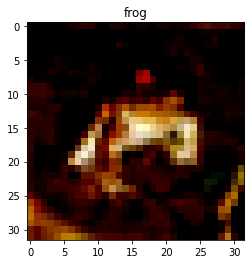

In [15]:
plt.imshow(img_permuted)
plt.title(class_names[label])

### 4.4 Binary classification subset (only 2 out of all 10 CIFAR10 classess)
as our first model VGG is not much comples I'll create a subset of all CIFAR data to perform binary classification (two classes). 
Let's train a model to learn to recognize the difference between only two classes eg. plane vs birds

In [75]:
#picking up indexes with wanted 2 targets
search_train_idx = np.where((np.array(train_data.targets) == 0) | (np.array(train_data.targets) == 2))[0]
search_test_test_idx = np.where((np.array(test_data.targets) == 0) | (np.array(test_data.targets) == 2))[0]
#create subsets based on indexes with wanted indexes (0 and 2 -> plane and birds)
train_data_binary = Subset(train_data, search_train_idx)
test_data_binary = Subset(test_data, search_test_test_idx)

## 5. Create dataloaders

In [17]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

### 5.1 Full CIFAR10 data dataloader

In [18]:
train_dataloader_full_data= DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                            num_workers=NUM_WORKERS)
test_dataloader_full_data = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                            num_workers=NUM_WORKERS)

In [19]:
#print dataloaders
print(f"DataLoaders: {train_dataloader_full_data, test_dataloader_full_data}")
print(f"length of train_dataloader: {len(train_dataloader_full_data)} batches of {BATCH_SIZE}")
print(f"length of test_dataLoader: {len(test_dataloader_full_data)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001ECC8AFE790>, <torch.utils.data.dataloader.DataLoader object at 0x000001ECC8AFE940>)
length of train_dataloader: 1563 batches of 32
length of test_dataLoader: 313 batches of 32


In [20]:
#check out whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader_full_data))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [21]:
#permute to be able to draw picture
train_features_batch_permuted = train_features_batch.permute(0,2,3,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image size: torch.Size([32, 32, 3])
Label : 4, label size: torch.Size([])


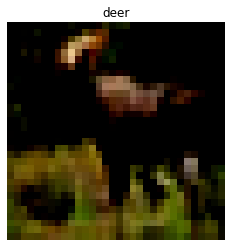

In [22]:
#random sample
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch_permuted), size=[1]).item()
img, label = train_features_batch_permuted[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(),cmap="gray")
plt.axis(False)
plt.title(train_data.classes[label])

print(f"Image size: {img.shape}")
print(f"Label : {label}, label size: {label.shape}")

### 5.2 binary_classification CIFAR10 (2 classes) data dataloaders

In [23]:
train_dataloader_binary= DataLoader(dataset=train_data_binary,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                            num_workers=NUM_WORKERS)
test_dataloader_binary = DataLoader(dataset=test_data_binary,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                            num_workers=NUM_WORKERS)

In [24]:
#check out whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader_binary))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [25]:
#print dataloaders
print(f"DataLoaders: {train_dataloader_binary, test_dataloader_binary}")
print(f"length of train_dataloader: {len(train_dataloader_binary)} batches of {BATCH_SIZE}")
print(f"length of test_dataLoader: {len(test_dataloader_binary)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x000001ECC8D4A2E0>, <torch.utils.data.dataloader.DataLoader object at 0x000001ECC8D4A280>)
length of train_dataloader: 313 batches of 32
length of test_dataLoader: 63 batches of 32


In [26]:
#permute to be able to draw picture
train_features_batch_permuted = train_features_batch.permute(0,2,3,1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image size: torch.Size([32, 32, 3])
Label : 2, label size: torch.Size([])


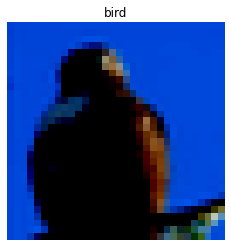

In [27]:
#random sample
#torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch_permuted), size=[1]).item()
img, label = train_features_batch_permuted[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(),cmap="gray")
plt.axis(False)
plt.title(train_data.classes[label])

print(f"Image size: {img.shape}")
print(f"Label : {label}, label size: {label.shape}")

## 6. Evaluating models on full data dataloaders (10 classes)

In [28]:
from MODULES.myModels import TinyVGG, CustomCNN
from MODULES import train_engine
from MODULES.utils import plot_loss_curves_from_df, plot_loss_curves_from_dict, save_model, make_predictions

### 6.1 TinyVGG model

In [29]:
HIDDEN_UNITS = 10

In [30]:
model_TinyVGG = TinyVGG(input_shape=3, # because of 3 dimensions of our date height, width, color
                hidden_units=HIDDEN_UNITS,
                output_shape=len(class_names)).to(device)

### 6.1 CustomCNN Model

In [31]:
model_CNN = CustomCNN().to(device)

### 6.2 model efficientnet_b0 (Transfer Learning)
using pretrained model for out problem

In [32]:
#best available weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model_effb0 = torchvision.models.efficientnet_b0(weights=weights).to(device)
#as default it is for 1000 classes
model_effb0.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [33]:
#checking model for sizes of our data
summary(model=model_effb0,
       input_size=(1,3,32,32),
       col_names=["input_size","output_size","num_params","trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 32, 32]       [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 32, 32]       [1, 1280, 1, 1]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 32, 32]       [1, 32, 16, 16]      --                   True
│    │    └─Conv2d (0)                                       [1, 3, 32, 32]       [1, 32, 16, 16]      864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 16, 16]      [1, 32, 16, 16]      64                   True
│    │    └─SiLU (2)                                         [1, 32, 16, 16]      [1, 32, 16, 16]      --                   --
│    └─Sequential (1)                                        [1, 32, 16, 16]      [1, 16, 16, 

freezing parameters --> prevent them from learning. This will apply to all but classifier layer

In [34]:
for p in model_effb0.features.parameters():
    p.requires_grad = False

Adjusting classifier layer for our needs --> 10 classes

In [35]:
model_effb0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), # prevents overfitting -- wyłącza niektóra neurony
    nn.Linear(in_features=1280, #feature vector coming in
             out_features=len(class_names)), # ilość naszych klas
)

## 6.2 Looping through all models with different settings

In [36]:
df_results = pd.DataFrame(columns=['train_loss','train_acc','test_loss','test_acc','experiment_nr','epoch','ttl_epochs','model','dataloaders','learning_rate','model_specification'])
## parameters below to search for best performing model

num_epochs = [3,6]
learning_rates = [0.001, 0.002]

dataloaders = {"data_10_classes": [train_dataloader_full_data, test_dataloader_full_data],
              "data_2_classes": [train_dataloader_binary, test_dataloader_binary]}

models = {"tinyVGG": model_TinyVGG,
         "CNN": model_CNN,
         "effb0": model_effb0}

In [37]:
#start times
from timeit import default_timer as timer
start_time = timer()

experiment_counter = 0
for dataloader_name, dataloaders_list in dataloaders.items():
    for epochs in num_epochs:
        for model_name, model in models.items():
            for lr in learning_rates:
                experiment_counter+=1
                print(f"[INFO] Experiment Number: {experiment_counter}")
                print(f"[INFO] Model: {model_name}")
                print(f"[INFO] DataLoader: {dataloader_name}")
                print(f"[INFO] Number of Epochs: {epochs}")
                print(f"[INFO] learning rate : {lr}")
                
                #create a new loss and optimizer for every model
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
                
                #train target model with target dataloader and track experiments
                results_dict= train_engine.train(model=model,
                                    train_dataloader=dataloaders_list[0],
                                    test_dataloader=dataloaders_list[1],
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=epochs,
                                    device=device)
                save_filepath = f"CIFAR10_{model_name}_{dataloader_name}_lr-{lr}_{epochs}_epochs.pth"
                
                ## storing results as df.Dataframe object
                results_df=pd.DataFrame(results_dict)
                results_df['experiment_nr'] = experiment_counter
                results_df['epoch'] = results_df.index+1
                results_df['ttl_epochs'] = epochs
                results_df['model'] = model_name
                results_df['dataloaders'] = dataloader_name
                results_df['learning_rate'] = lr
                results_df['model_specification'] = save_filepath
                df_results=pd.concat([df_results,results_df],ignore_index=True)
                
                #save model to a file
                save_model(model=model,
                           target_dir="models",
                           model_name=save_filepath)
                print("-"*50+"\n")

end_time = timer()
print(f"[INFO] Total Training time: {end_time-start_time:.3f} seconds")

IndentationError: unexpected indent (Temp/ipykernel_50104/800790881.py, line 9)

In [38]:
#export data to excel
df_results.to_excel(OUTPUT/"RESULTS_.xlsx", sheet_name="results")

## 7 Visalizing best models

In [39]:
#we can work here in previously created df_results or just reload the data from excel
df_ws = pd.read_excel(OUTPUT/"RESULTS.xlsx", sheet_name="results", index_col=0)

### 7.1 picking up best models for each dataloaders

In [40]:
#'train_loss', 'train_acc', 'test_loss', 'test_acc'
SORT_COLUMN = 'test_acc'

In [41]:
#data_10_classes --> train_dataloader_full_data
best_result_model_10_classes = df_ws[df_ws["dataloaders"]=="data_10_classes"].sort_values(by=[SORT_COLUMN],ascending=False).head(1)[['model_specification','model',SORT_COLUMN]]
best_result_model_10_classes

,model_specification,model,test_acc
30,CIFAR10_CNN_data_10_classes_lr-0.001_6_epochs.pth,CNN,0.746905


In [42]:
#data_2_classes --> train_dataloader_binary
best_result_model_2_classes = df_ws[df_ws["dataloaders"]=="data_2_classes"].sort_values(by=[SORT_COLUMN],ascending=False).head(1)[['model_specification','model',SORT_COLUMN]]
best_result_model_2_classes

,model_specification,model,test_acc
88,CIFAR10_CNN_data_2_classes_lr-0.001_6_epochs.pth,CNN,0.925099


### 7.2 ploting test curve

In [43]:
#picking up the data for best models
#10 classes
df_best_result_10_classes = df_ws[df_ws['model_specification']==best_result_model_10_classes['model_specification'].values[0]]
df_best_result_10_classes = df_best_result_10_classes[['train_loss', 'train_acc', 'test_loss', 'test_acc','epoch']]

#2 classes
df_best_result_2_classes = df_ws[df_ws['model_specification']==best_result_model_2_classes['model_specification'].values[0]]
df_best_result_2_classes = df_best_result_2_classes[['train_loss', 'train_acc', 'test_loss', 'test_acc','epoch']]

### 7.3 visualizing CNN 10 classes top model

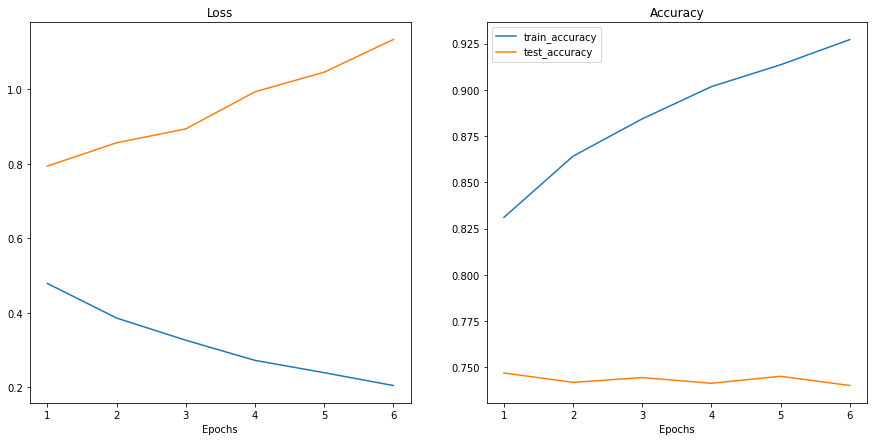

In [44]:
plot_loss_curves_from_df(df_best_result_10_classes)

In [45]:
df_best_result_10_classes

,train_loss,train_acc,test_loss,test_acc,epoch
30,0.478578,0.830994,0.793856,0.746905,1
31,0.385776,0.864123,0.856496,0.741813,2
32,0.326177,0.884277,0.893661,0.744409,3
33,0.272048,0.901711,0.993246,0.741314,4
34,0.238965,0.913528,1.046029,0.745108,5
35,0.204479,0.927143,1.133666,0.740116,6


### 7.4 visualizing CNN 2 classes top model

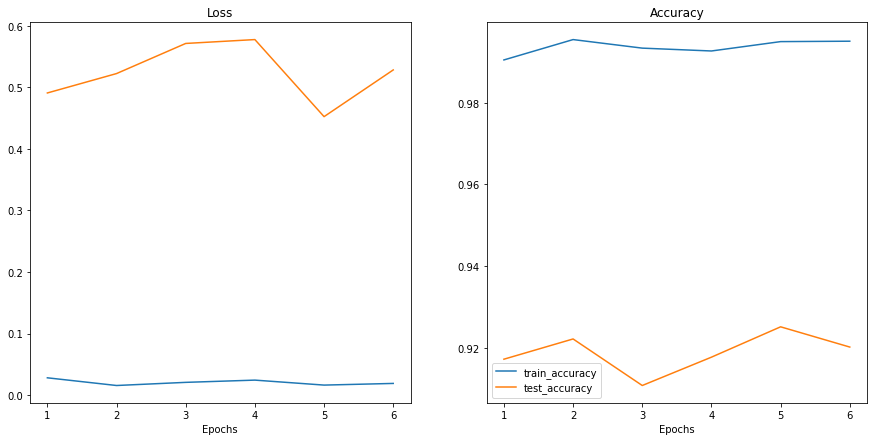

In [46]:
plot_loss_curves_from_df(df_best_result_2_classes)

In [47]:
df_best_result_2_classes

,train_loss,train_acc,test_loss,test_acc,epoch
84,0.028102,0.990515,0.490756,0.917163,1
85,0.015605,0.995507,0.522261,0.922123,2
86,0.020710,0.993411,0.571181,0.910714,3
87,0.024350,0.992712,0.577467,0.917659,4
88,0.016273,0.995008,0.452306,0.925099,5
89,0.018979,0.995108,0.528172,0.920139,6


## 8 Load best model (10 class) and evaluating it on random pictures

### 8.1 loading best model (10 classes)from MODELS/

In [67]:
loaded_model = models[best_result_model_10_classes['model'].values[0]]

In [68]:
best_model_10_path = MODELS / best_result_model_10_classes['model_specification'].values[0]

In [69]:
loaded_model.load_state_dict(torch.load(f=best_model_10_path))

<All keys matched successfully>

### 8.2 picking 9 samples pictures at random for predictions

In [70]:
test_samples= []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)

### 8.3 making predictions

In [71]:
#make predictions
pred_probs = make_predictions(model=loaded_model,data=test_samples, device=device)
#converting prediction probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 8, 1, 4, 3, 9, 5, 1, 7])

In [72]:
test_labels

[9, 8, 8, 7, 3, 9, 5, 1, 7]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


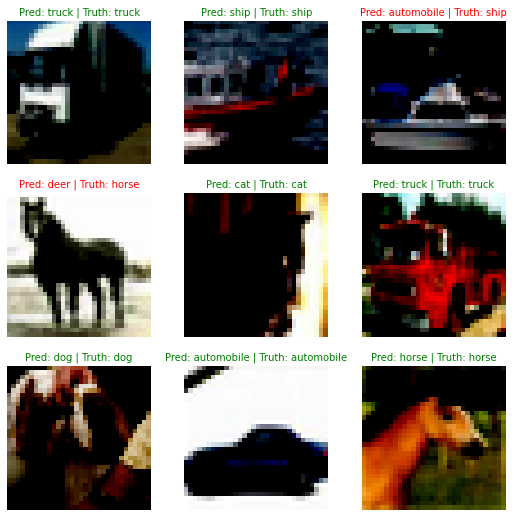

In [73]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    #create a sublot
    plt.subplot(nrows, ncols, i+1)
    
    sample = sample.permute(1,2,0)
    #plot the target image
    plt.imshow(sample.squeeze())
    
    #find the prediction (in text form eg Sandal)
    pred_label = class_names[pred_classes[i]]
    
    #get the truth label (in text form)
    truth_label = class_names[test_labels[i]]
    
    #create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    #check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
        
    plt.axis(False)

## x. Notes

In [74]:
#instead of my plotting method i could use tensorboard